#14_CNN_DNN모델클래스화

###ML 라이브러리: Pytorch(GPU)

In [ ]:
import torch
import torchvision.datasets as data
import torchvision.transforms as transforms
import random

GPU 사용을 명시적으로 보여주기 & Random Seed 고정하기

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

학습 파라미터 설정

In [ ]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

##1. 데이터셋 불러오기

In [ ]:
mnist_train = data.MNIST(root = 'MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)

mnist_test = data.MNIST(root = 'MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)

DataLoader: 데이터를 알맞게 나눠준다

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset = mnist_train, batch_size = batch_size, shuffle = True, drop_last = True)
#dataset = mnist_train: 처리할 데이터
#batch_size = batch_size: batch_size만큼씩 데이터를 잘라러 준다
#shuffle = True: 데이터를 섞는다
#drop_last: 모든 데이터 개수 % batch_size > 0 일 때 나머지 데이터를 버린다

##5. 모델 추정

###모델 정의: DNN 모델 클래스화

DNN 모델 클래스화

In [ ]:
class NN(torch.nn.Module):
    #모델의 구조와 동작을 정의하는 생성자(객체가 생성될때 호출)
    def __init__(self):
        #super()함수를 부르면 여기서 만든 클래스는 nn.Module 클래스의 속성을 가지고 초기화된다
        super(NN, self).__init__()
        
        #NN Layer & ReLU
        self.linear1 = torch.nn.Linear(784, 512, bias = True)
        self.linear2 = torch.nn.Linear(512, 512, bias = True)
        self.linear3 = torch.nn.Linear(512, 512, bias = True)
        self.linear4 = torch.nn.Linear(512, 512, bias = True)
        self.linear5 = torch.nn.Linear(512, 10, bias = True)
        self.relu = torch.nn.ReLU()

        #Weight Initialization: Xavier Init
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)
        torch.nn.init.xavier_uniform_(self.linear4.weight)
        torch.nn.init.xavier_uniform_(self.linear5.weight)
    
    #forward() 함수는 모델이 학습데이터를 입력 받아서 forward 연산을 진행시키는 함수
    #torch.nn.Squential()과 유사
    #이 함수는 모델 객체를 데이터와 함께 호출하면 자동으로 실행된다
    # ex. model이란 이름의 객체를 생성하고 model(입력 데이터)와 같은 형식으로 객체를 호출하면 자동으로 forward 연산이 수행된다
    #H(x) 식에서 입력 x로부터 예측된 y를 얻는 것을 forward 연산이라고 한다
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)
        out = self.relu(out)
        out = self.linear5(out)
        return out

DNN 모델 클래스 호출

In [ ]:
#NN() 클래스를 호출하여 model 정의
model = NN().to(device)

###모델 학습

Cross Entropy Loss & Adam Optimizer

In [ ]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
total_batch = len(data_loader)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader: #앞에서 알맞게 나눠둔 데이터를 X, Y에 넣어준다

        # (mini batch_size, 1, 가로, 세로)
        # (100, 1, 28, 28) 크기의 텐서를 (1000, 28*28) 크기의 텐서로 바꿔준다
        X= X.view(-1, 28 * 28).to(device) # 2D 데이터를 1D 데이터로 눌러준다
        # One-hot Encoding되어 있지 않다
        Y = Y.to(device)

        # Gradient Initialization
        optimizer.zero_grad()

        # Forward 계산
        hypothesis = model(X)

        # Cost : Error 계산
        cost = loss(hypothesis, Y)

        # Backpropagation
        cost.backward()

        # Cost로 가중치(W, b) 갱신
        optimizer.step()

        # 평균 Error 계산
        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished')

Epoch: 0001 cost = 0.211102009
Epoch: 0002 cost = 0.091821641
Epoch: 0003 cost = 0.063954882
Epoch: 0004 cost = 0.050993722
Epoch: 0005 cost = 0.041720200
Epoch: 0006 cost = 0.036938973
Epoch: 0007 cost = 0.030179033
Epoch: 0008 cost = 0.022753322
Epoch: 0009 cost = 0.024053456
Epoch: 0010 cost = 0.022215230
Epoch: 0011 cost = 0.019339055
Epoch: 0012 cost = 0.015723050
Epoch: 0013 cost = 0.020411827
Epoch: 0014 cost = 0.018291520
Epoch: 0015 cost = 0.013467304
Learning Finished


##6. 결과 분석

Accuracy

In [ ]:
#앞서 모델 학습 과정에서는 required_grad = True로 되어있어 학습 중임을 나타낸다
#False는 학습 중이 아님을, 모델 평가 중임을 나타낸다

with torch.no_grad(): #임시로 required_grad = False로 설정하는 것과 같다

  X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
  Y_test = mnist_test.test_labels.to(device)

  prediction = model(X_test)

  correct_prediction = torch.argmax(prediction, 1) == Y_test

  accuracy = correct_prediction.float().mean()

  print('Accuracy:', accuracy.item())

Accuracy: 0.9807999730110168


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Random Test: 한 데이터만

In [ ]:
r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

print('Label: ', Y_single_data.item())
single_prediction = model(X_single_data)
print('Prediction: ', torch.argmax(single_prediction, 1).item())

Label:  8
Prediction:  8


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Random Test한 데이터 시각화하기

tensor([8], device='cuda:0')


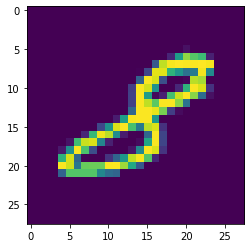

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_single_data.reshape(28,28).cpu()) # 1D -> 2D
print(Y_single_data)